In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.0 MB/s eta 0:00:00


In [2]:
# import libraries for this Assignments
import cv2
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import time

In [3]:
from functools import total_ordering
# Defining the Environment.
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.environment_width = 5
        self.environment_height = 5

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4) #right, left, up, down
        self.max_timesteps = 20
        self.prize_pos = np.asarray([[1, 1], [4, 2], [0, 4]])  # states of positive rewards
        self.stone_pos = np.asarray([[4, 0], [2, 2], [1, 3]])  # States of negative (-10) rewards 
        self.fence_pos = np.asarray([[3, 0], [4, 4]])  # States of negative (-12) rewards
        self.goal_quantity = 1
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        #self.state = np.zeros((5,5))
        #self.state[tuple(self.agent_pos)] = 1
        #self.state[tuple(self.goal_pos)] = 0.5
        self.terminated = False
        self.total_reward = 0

        
    def reset(self):

        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 1
        #self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()

        info = {}

        return observation, info
 
 
 # Describing the various possible actions.   
    def step(self, action):
        
        if action == 0:
          self.agent_pos[0] += 1 # This right action.
        if action == 1:
          self.agent_pos[0] -= 1 # This left action.
        if action == 2:
          self.agent_pos[1] += 1  # This up action.
        if action == 3:
          self.agent_pos[1] -= 1  # This down action.


        reward = 0
         
      # check the next stage of the agent
        for pos in self.prize_pos:
          if np.all(pos == self.agent_pos):
            reward =10
            break 
        for pos in self.stone_pos:
          if np.all(pos == self.agent_pos):
            reward =-5
            break
        for pos in self.fence_pos:
          if np.all(pos == self.agent_pos):
            reward =-12
            break
        for pos in self.goal_pos:
          if np.all(pos == self.agent_pos):
            reward =20
            self.terminated = True   
            break
        
    
    # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 4)

        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 1
        #self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        
             
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 2)) else False

        info = {}
        
        return observation, reward, terminated, truncated, info
        
    def render(self, mode='human', plot=False):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)

        def plot_image(plot_pos):
          plot_agent, plot_stone, plot_prize, plot_fence, plot_goal = False, False, False, False, False

          # Checking which objects need to be plotted by comparing their positions.
          if np.array_equal(self.agent_pos, plot_pos):
            plot_agent = True
          if any(np.array_equal(self.stone_pos[i], plot_pos) for i in range(len(self.stone_pos))):
            plot_stone = True
          if self.goal_quantity > 0:  # Goal isn't plotted if it has already been picked by one of the agents.
            if np.array_equal(plot_pos, self.goal_pos):
              plot_goal = True
          if any(np.array_equal(self.prize_pos[i], plot_pos) for i in range(len(self.prize_pos))):
            plot_prize = True
          if any(np.array_equal(self.fence_pos[i], plot_pos) for i in range(len(self.fence_pos))):
            plot_fence = True


            
          # Plot for Agent.
          if plot_agent and all(not item for item in [plot_stone, plot_goal, plot_prize, plot_fence]):
            agent = AnnotationBbox(OffsetImage(plt.imread('./walker.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent)

          # Plot for Stone.
          elif plot_stone and all(not item for item in [plot_agent, plot_goal, plot_prize, plot_fence]):
            stone = AnnotationBbox(OffsetImage(plt.imread('./stone.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(stone)


          # Plot for Fence.
          elif plot_fence and all(not item for item in [plot_agent, plot_goal, plot_prize, plot_stone]):
            fence = AnnotationBbox(OffsetImage(plt.imread('./fence.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(fence)

          
          # Plot for Goal.
          elif plot_goal and all(not item for item in [plot_agent, plot_stone, plot_prize, plot_fence]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./goal.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)

            # Plot for Prize.
          elif plot_prize and all(not item for item in [plot_agent, plot_stone, plot_goal, plot_fence]):
            prize = AnnotationBbox(OffsetImage(plt.imread('./prize.jpeg'), zoom=0.28),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(prize)

            # Plot for Agent and stone.
          elif all(item for item in [plot_agent, plot_stone]) and all(not item for item in [plot_goal, plot_prize, plot_fence]):
            agent_stone = AnnotationBbox(OffsetImage(plt.imread('./walker_stone.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent_stone)


            # Plot for Agent and fence.
          elif all(item for item in [plot_agent, plot_fence]) and all(not item for item in [plot_goal, plot_prize, plot_stone]):
            agent_fence = AnnotationBbox(OffsetImage(plt.imread('./walker_fence.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent_fence)


            # Plot for Agent and Prize.
          elif all(item for item in [plot_agent, plot_prize]) and all(not item for item in [plot_stone, plot_goal, plot_fence]):
            agent_prize = AnnotationBbox(OffsetImage(plt.imread('./walker_prize.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent_prize)

         # Plot for Agent and Goal.
          elif all(item for item in [plot_agent, plot_goal]) and all(not item for item in [plot_stone, plot_prize, plot_fence]):
            agent_goal = AnnotationBbox(OffsetImage(plt.imread('./walker_goal.jpeg'), zoom=0.28), np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent_goal)


        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray([j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4])
        plt.yticks([0, 1, 2, 3, 4])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image


        

In [4]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

Initaial state: S1


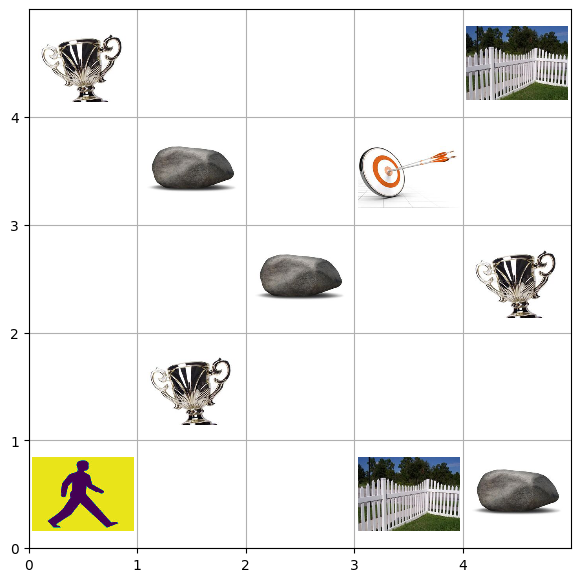

Current State: S1 , Action: Up , Next State: S6 , Reward: 0 , Total Reward: 0


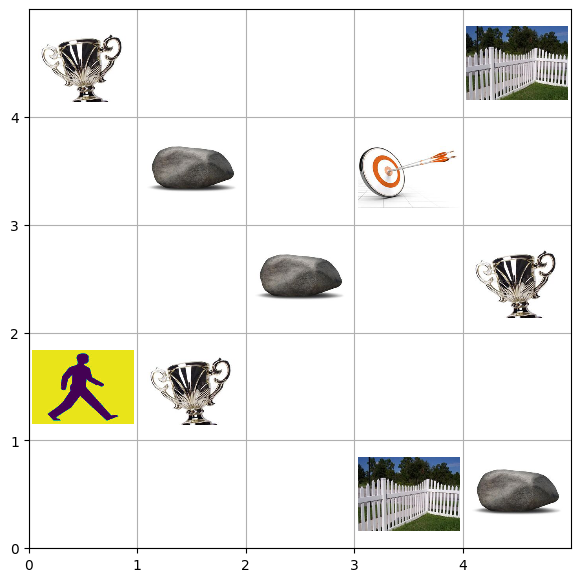

Current State: S6 , Action: Right , Next State: S7 , Reward: 10 , Total Reward: 10


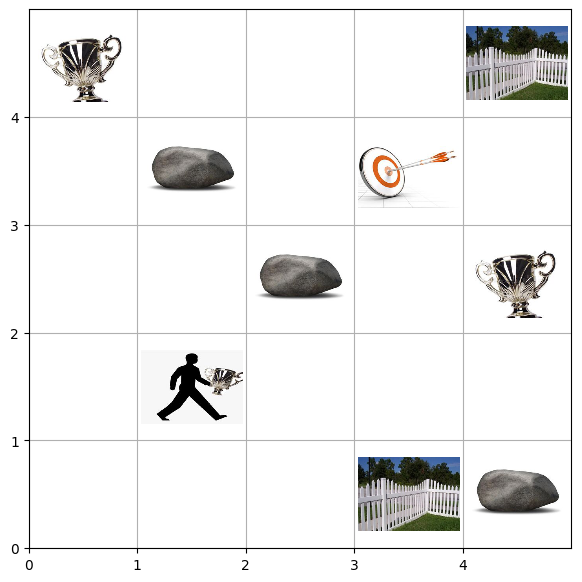

Current State: S7 , Action: Up , Next State: S12 , Reward: 0 , Total Reward: 10


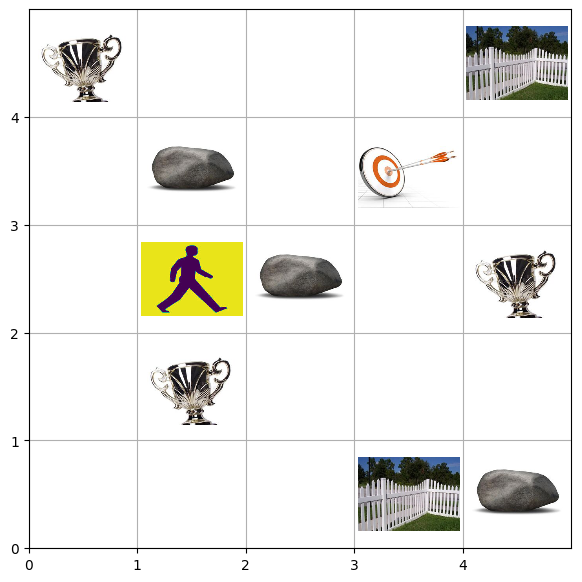

Current State: S12 , Action: Right , Next State: S13 , Reward: -5 , Total Reward: 5


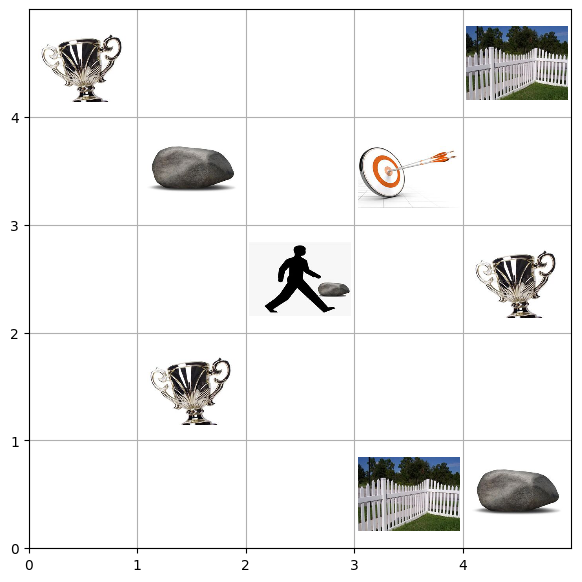

Current State: S13 , Action: Right , Next State: S14 , Reward: 0 , Total Reward: 5


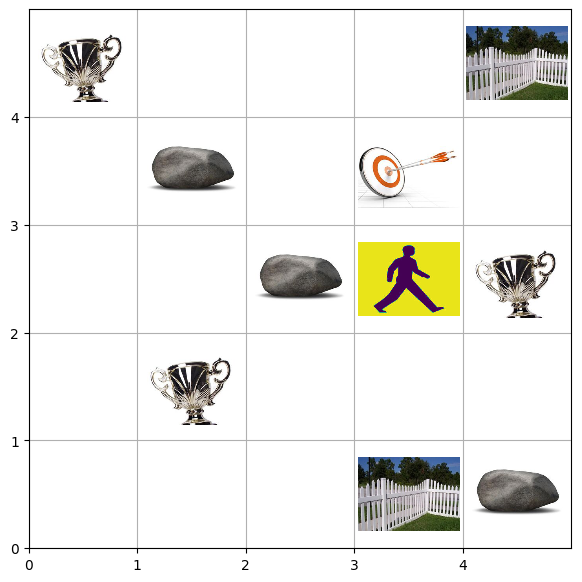

Current State: S14 , Action: Left , Next State: S13 , Reward: -5 , Total Reward: 0


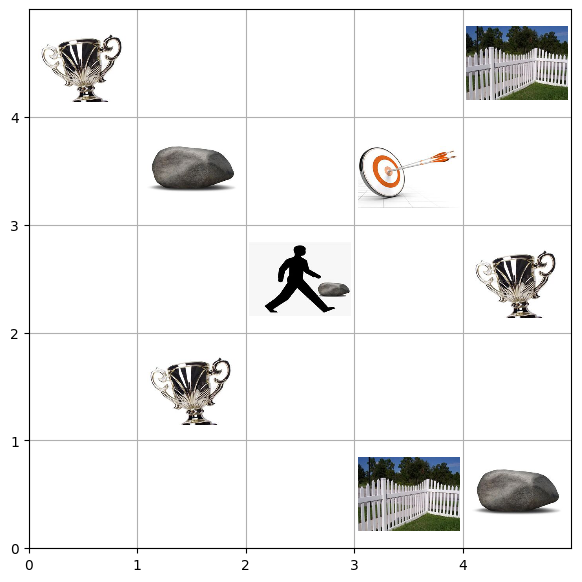

Current State: S13 , Action: Left , Next State: S12 , Reward: 0 , Total Reward: 0


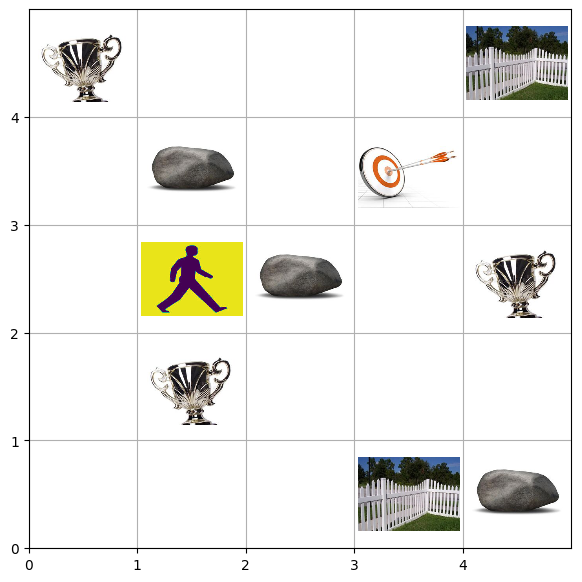

Current State: S12 , Action: Left , Next State: S11 , Reward: 0 , Total Reward: 0


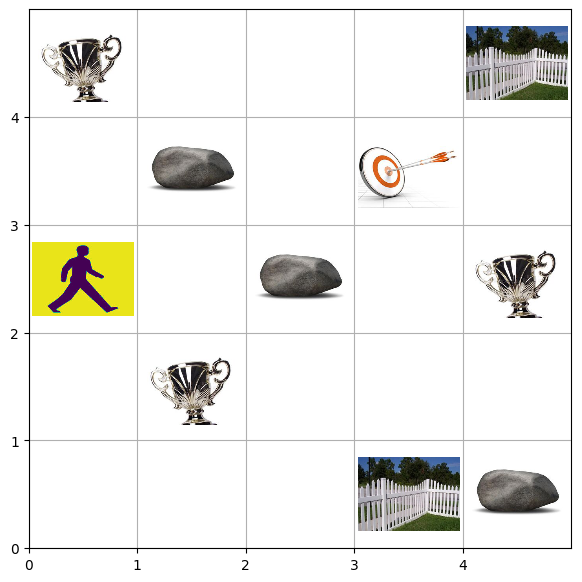

Current State: S11 , Action: Right , Next State: S12 , Reward: 0 , Total Reward: 0


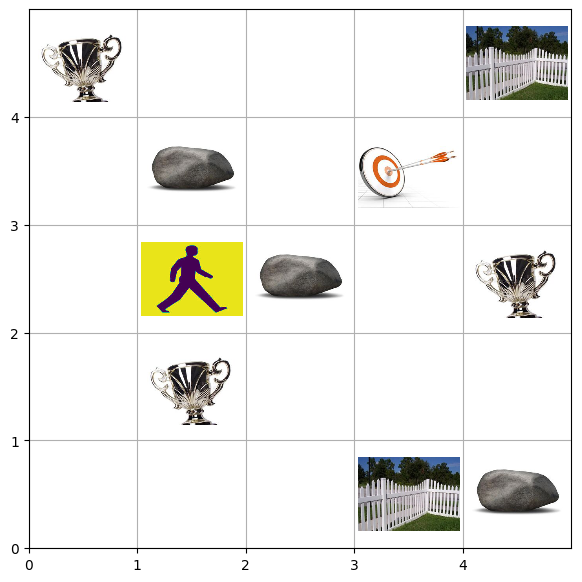

Current State: S12 , Action: Up , Next State: S17 , Reward: -5 , Total Reward: -5


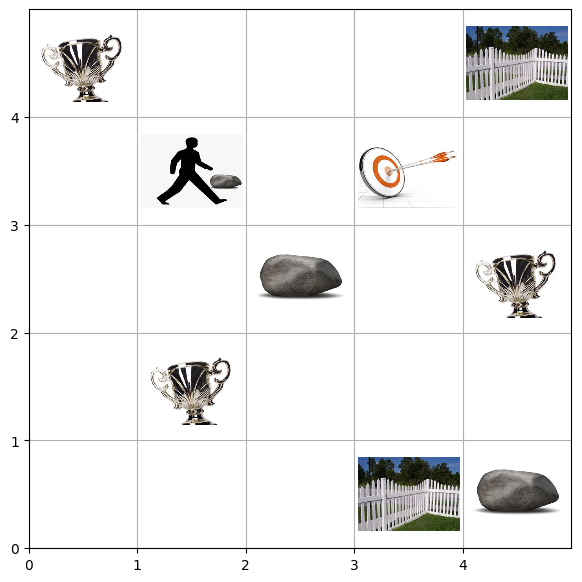

Current State: S17 , Action: Up , Next State: S22 , Reward: 0 , Total Reward: -5


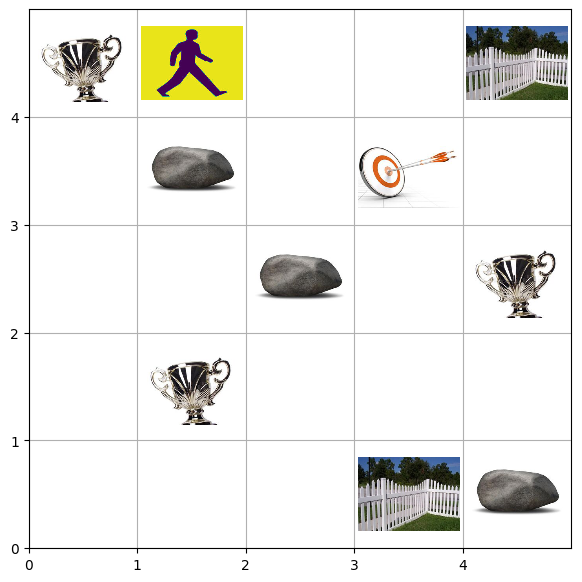

Current State: S22 , Action: Down , Next State: S17 , Reward: -5 , Total Reward: -10


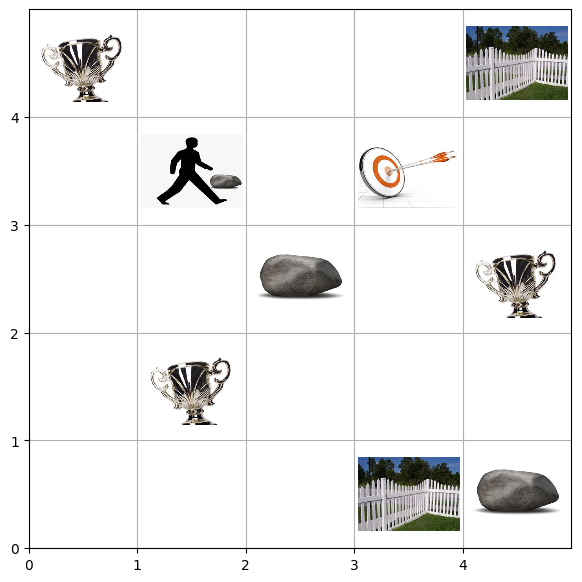

Current State: S17 , Action: Down , Next State: S12 , Reward: 0 , Total Reward: -10


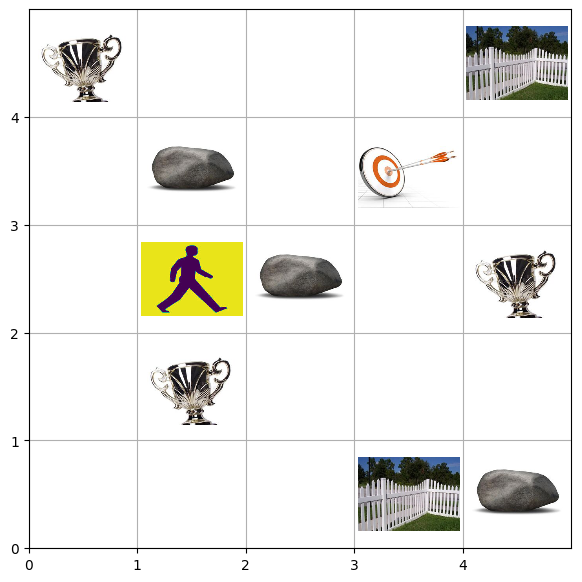

Current State: S12 , Action: Down , Next State: S7 , Reward: 10 , Total Reward: 0


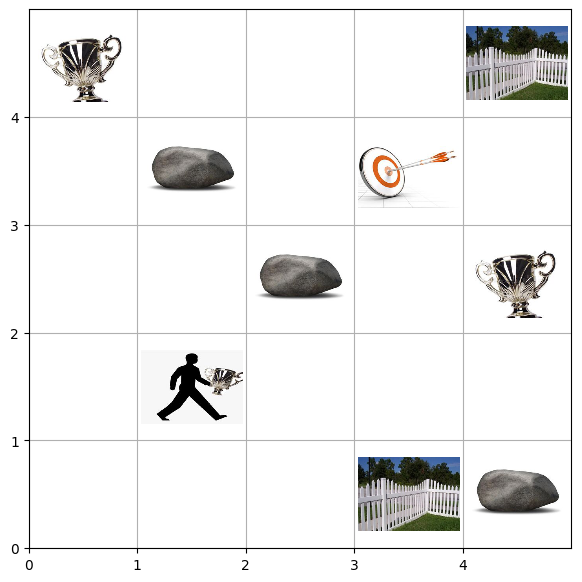

Current State: S7 , Action: Up , Next State: S12 , Reward: 0 , Total Reward: 0


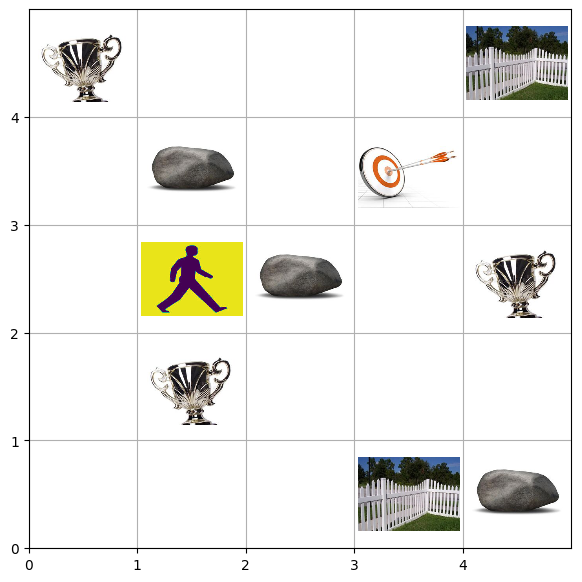

Current State: S12 , Action: Up , Next State: S17 , Reward: -5 , Total Reward: -5


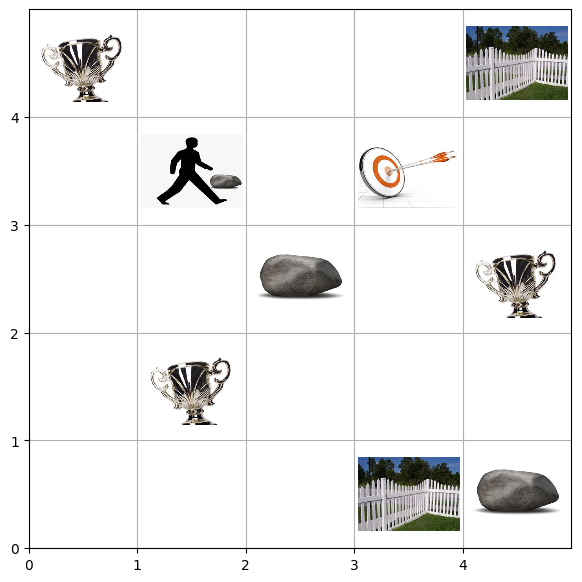

Current State: S17 , Action: Left , Next State: S16 , Reward: 0 , Total Reward: -5


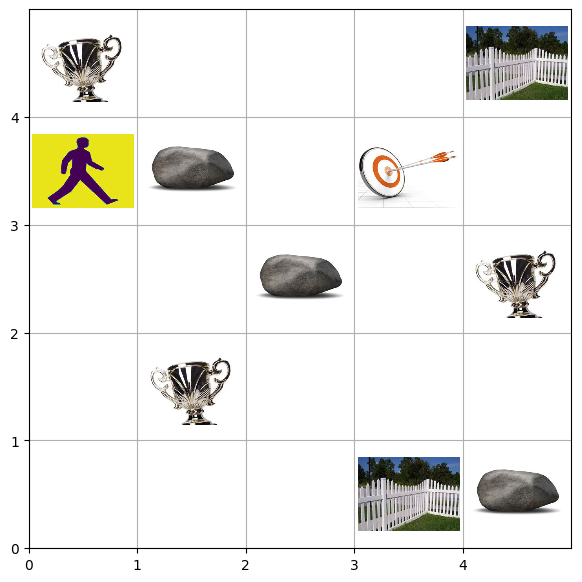

Current State: S16 , Action: Left , Next State: S16 , Reward: 0 , Total Reward: -5


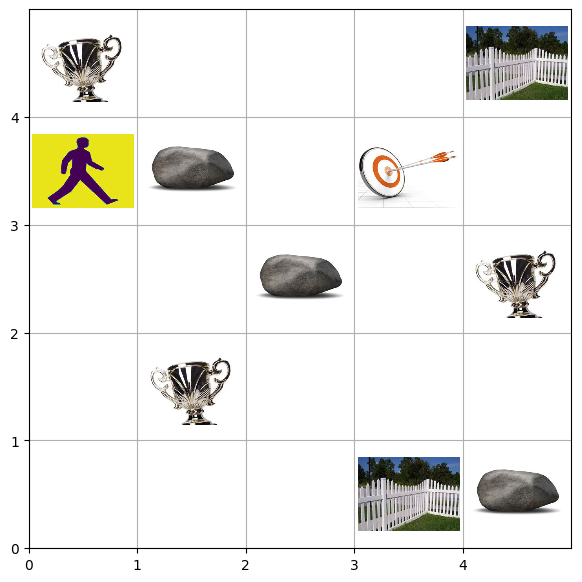

Current State: S16 , Action: Left , Next State: S16 , Reward: 0 , Total Reward: -5


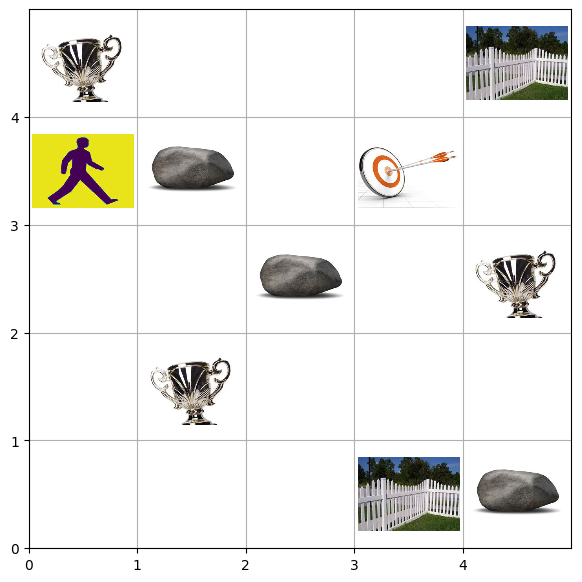

Current State: S16 , Action: Right , Next State: S17 , Reward: -5 , Total Reward: -10


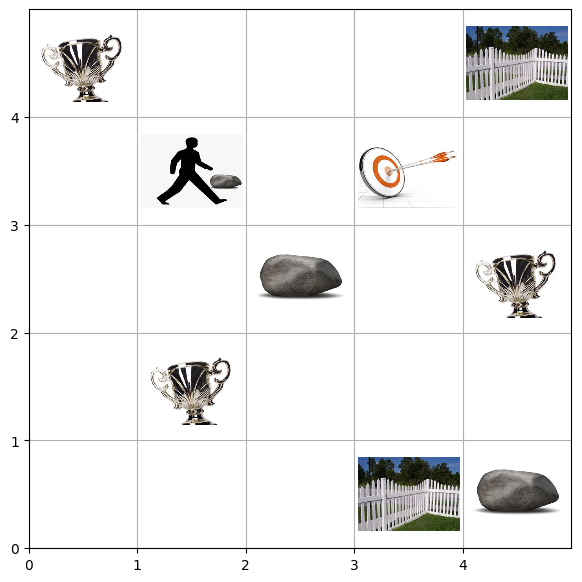

In [5]:
env = GridEnvironment()
agent = RandomAgent(env)

# reset the enviroment
obs, info = env.reset()
print ("Initaial state: S1")
terminated, truncated = False, False

env.render()
total_reward = 0
while not terminated:
  if obs[0] == 1:
    current_state = "S1"
  elif obs[1] == 1:
    current_state = "S6" 
  elif obs[2] == 1:
    current_state = "S11"
  elif obs[3] == 1:
    current_state = "S16"
  elif obs[4] == 1:
    current_state = "S21"
  elif obs[5] == 1:
    current_state = "S2"
  elif obs[6] == 1:
    current_state = "S7"
  elif obs[7] == 1:
    current_state = "S12"
  elif obs[8] == 1:
    current_state = "S17"
  elif obs[9] == 1:
    current_state = "S22"
  elif obs[10] == 1:
    current_state = "S3"
  elif obs[11] == 1:
    current_state = "S8"
  elif obs[12] == 1:
    current_state = "S13"
  elif obs[13] == 1:
    current_state = "S18"
  elif obs[14] == 1:
    current_state = "S23"  
  elif obs[15] == 1:
    current_state = "S4" 
  elif obs[16] == 1:
    current_state = "S9"
  elif obs[17] == 1:
    current_state = "S14"
  elif obs[18] == 1:
    current_state = "S19"
  elif obs[19] == 1:
    current_state = "S24"  
  elif obs[20] == 1:
    current_state = "S5"  
  elif obs[21] == 1:
    current_state = "S10"
  elif obs[22] == 1:
    current_state = "S15"
  elif obs[23] == 1:
    current_state = "S20"    
  elif obs[24] == 1:
    current_state = "S25" 
  action = agent.step(obs)
  if action == 0:
    act = "Right"
  elif action == 1:
    act = "Left"
  elif action == 2:
    act = "Up"
  else:
    act = "Down"  

  obs, reward, terminated, truncated, info = env.step(action)
  if obs[0] == 1:
    state = "S1"
  elif obs[1] == 1:
    state = "S6" 
  elif obs[2] == 1:
    state = "S11"
  elif obs[3] == 1:
    state = "S16"
  elif obs[4] == 1:
    state = "S21"
  elif obs[5] == 1:
    state = "S2"
  elif obs[6] == 1:
    state = "S7"
  elif obs[7] == 1:
    state = "S12"
  elif obs[8] == 1:
    state = "S17"
  elif obs[9] == 1:
    state = "S22"
  elif obs[10] == 1:
    state = "S3"
  elif obs[11] == 1:
    state = "S8"
  elif obs[12] == 1:
    state = "S13"
  elif obs[13] == 1:
    state = "S18"
  elif obs[14] == 1:
    state = "S23"  
  elif obs[15] == 1:
    state = "S4" 
  elif obs[16] == 1:
    state = "S9"
  elif obs[17] == 1:
    state = "S14"
  elif obs[18] == 1:
    state = "S19"
  elif obs[19] == 1:
    state = "S24"  
  elif obs[20] == 1:
    state = "S5"  
  elif obs[21] == 1:
    state = "S10"
  elif obs[22] == 1:
    state = "S15"
  elif obs[23] == 1:
    state = "S20"    
  elif obs[24] == 1:
    state = "S25"  
  total_reward +=reward
  print ("Current State:", current_state, ", Action:", act, ", Next State:", state, ", Reward:", reward, ", Total Reward:", total_reward)
  env.render()
  time.sleep(1)

SARSA

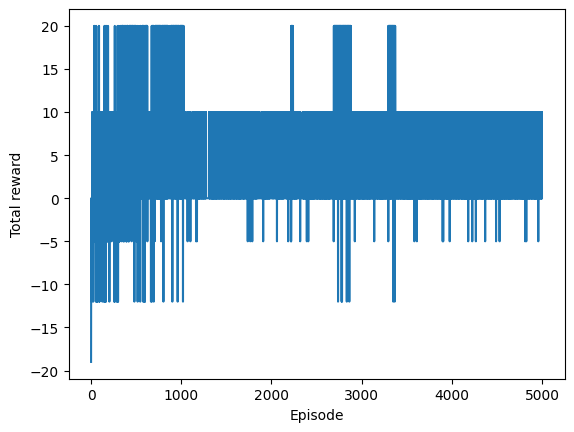

In [24]:
env = GridEnvironment()
agent = RandomAgent(env)


# Initialize Q-table
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay_rate = 0.001
num_episodes = 5000
max_timesteps = 100

# Lists for storing rewards
rewards = []
total_reward = 0

# SARSA algorithm
for i in range(num_episodes):
    obs1, info = env.reset()
    action = agent.step(state)
    
    if obs1[0] == 1:
      state = 0
    elif obs1[1] == 1:
      state = 5 
    elif obs1[2] == 1:
      state = 10
    elif obs1[3] == 1:
      state = 15
    elif obs1[4] == 1:
      state = 20
    elif obs1[5] == 1:
      state = 1
    elif obs1[6] == 1:
      state = 6
    elif obs1[7] == 1:
      state = 11
    elif obs1[8] == 1:
      state = 16
    elif obs1[9] == 1:
      state = 21
    elif obs1[10] == 1:
      state = 2
    elif obs1[11] == 1:
      state = 7
    elif obs1[12] == 1:
      state = 12
    elif obs1[13] == 1:
      state = 17
    elif obs1[14] == 1:
      state = 22  
    elif obs1[15] == 1:
      state = 3 
    elif obs1[16] == 1:
      state = 8
    elif obs1[17] == 1:
      state = 13
    elif obs1[18] == 1:
      state = 18
    elif obs1[19] == 1:
      state = 23  
    elif obs1[20] == 1:
      state = 4  
    elif obs1[21] == 1:
      state = 9
    elif obs1[22] == 1:
      state = 14
    elif obs1[23] == 1:
      state = 19    
    elif obs1[24] == 1:
      state = 24
    
    done = False
    timesteps = 0
        
    while not done and timesteps < max_timesteps:
        # Epsilon-greedy policy
        if np.random.random() < epsilon:
          action = agent.step(state)
        else:
            action = np.argmax(Q[state, :])
        
        obs2, reward, done, truncated, _ = env.step(action)
        
        if np.random.random() < epsilon:
            next_action = env.action_space.sample()
        else:
            next_action = np.argmax(Q[next_state, :])
        
        if obs2[0] == 1:
          next_state = 0
        elif obs2[1] == 1:
          next_state = 5 
        elif obs2[2] == 1:
          next_state = 10
        elif obs2[3] == 1:
          next_state = 15
        elif obs2[4] == 1:
          next_state = 20
        elif obs2[5] == 1:
          next_state = 1
        elif obs2[6] == 1:
          next_state = 6
        elif obs2[7] == 1:
          next_state = 11
        elif obs2[8] == 1:
          next_state = 16
        elif obs2[9] == 1:
          next_state = 21
        elif obs2[10] == 1:
          next_state = 2
        elif obs2[11] == 1:
          next_state = 7
        elif obs2[12] == 1:
          next_state = 12
        elif obs2[13] == 1:
          next_state = 17
        elif obs2[14] == 1:
          next_state = 22  
        elif obs2[15] == 1:
          next_state = 3 
        elif obs2[16] == 1:
          next_state = 8
        elif obs2[17] == 1:
          next_state = 13
        elif obs2[18] == 1:
          next_state = 18
        elif obs2[19] == 1:
          next_state = 23  
        elif obs2[20] == 1:
          next_state = 4  
        elif obs2[21] == 1:
          next_state = 9
        elif obs2[22] == 1:
          next_state = 14
        elif obs2[23] == 1:
          next_state = 19    
        elif obs2[24] == 1:
          next_state = 24
        
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
        
        obs1 = obs2
        action = next_action
        total_reward += reward
        timesteps += 1
    
    rewards.append(total_reward)
    total_reward = 0
    
    # Decay epsilon
    epsilon = max(0.1, epsilon - epsilon_decay_rate)

env.close()

# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()


In [7]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


Hyperparameter Tuning

[I 2023-05-13 17:16:02,152] A new study created in memory with name: no-name-b077bffa-ef51-4a53-8df2-a4af1171f962
[I 2023-05-13 17:16:04,111] Trial 0 finished with value: 6.9865 and parameters: {'gamma': 0.6853824851317099, 'epsilon_decay_rate': 0.001969488102519622, 'max_timesteps': 75}. Best is trial 0 with value: 6.9865.
[I 2023-05-13 17:16:06,147] Trial 1 finished with value: 4.4192 and parameters: {'gamma': 0.8110866944753741, 'epsilon_decay_rate': 0.009726298323483222, 'max_timesteps': 176}. Best is trial 0 with value: 6.9865.
[I 2023-05-13 17:16:07,747] Trial 2 finished with value: 7.1136 and parameters: {'gamma': 0.32142887031754486, 'epsilon_decay_rate': 0.004923638004808455, 'max_timesteps': 115}. Best is trial 2 with value: 7.1136.
[I 2023-05-13 17:16:10,118] Trial 3 finished with value: 6.9987 and parameters: {'gamma': 0.9621176599388254, 'epsilon_decay_rate': 0.0009234115990313545, 'max_timesteps': 122}. Best is trial 2 with value: 7.1136.
[I 2023-05-13 17:16:11,870] Trial

Best parameters: {'gamma': 0.5376520433641404, 'epsilon_decay_rate': 0.007209584368174786, 'max_timesteps': 130}
Best reward: 8.8908


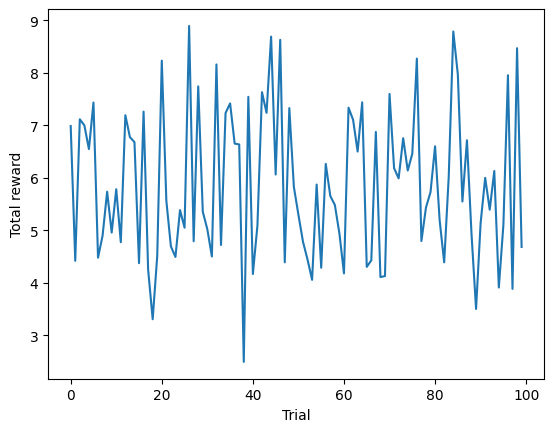

In [22]:
import optuna

def objective(trial):
    env = GridEnvironment()
    agent = RandomAgent(env)
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    alpha = 0.1
    gamma = trial.suggest_float('gamma', 0.1, 1.0)
    epsilon = 1.0
    epsilon_decay_rate = trial.suggest_float('epsilon_decay_rate', 0.0001, 0.01)
    num_episodes = 10000
    max_timesteps = trial.suggest_int('max_timesteps', 50, 200)
    rewards = []
    total_reward = 0
    
    for i in range(num_episodes):
        obs3, info = env.reset()
        if obs3[0] == 1:
          state = 0
        elif obs3[1] == 1:
          state = 5 
        elif obs3[2] == 1:
          state = 10
        elif obs3[3] == 1:
          state = 15
        elif obs3[4] == 1:
          state = 20
        elif obs3[5] == 1:
          state = 1
        elif obs3[6] == 1:
          state = 6
        elif obs3[7] == 1:
          state = 11
        elif obs3[8] == 1:
          state = 16
        elif obs3[9] == 1:
          state = 21
        elif obs3[10] == 1:
          state = 2
        elif obs3[11] == 1:
          state = 7
        elif obs3[12] == 1:
          state = 12
        elif obs3[13] == 1:
          state = 17
        elif obs3[14] == 1:
          state = 22  
        elif obs3[15] == 1:
          state = 3 
        elif obs3[16] == 1:
          state = 8
        elif obs3[17] == 1:
          state = 13
        elif obs3[18] == 1:
          state = 18
        elif obs3[19] == 1:
          state = 23  
        elif obs3[20] == 1:
          state = 4  
        elif obs3[21] == 1:
          state = 9
        elif obs3[22] == 1:
          state = 14
        elif obs3[23] == 1:
          state = 19    
        elif obs3[24] == 1:
          state = 24




        action = agent.step(state)
        done = False
        timesteps = 0
        
        while not done and timesteps < max_timesteps:
            if np.random.random() < epsilon:
              action = agent.step(state)
            else:
                action = np.argmax(Q[state, :])
                
            obs4, reward, done, truncated, _ = env.step(action)
            
            if np.random.random() < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q[next_state, :])
            
            if obs4[0] == 1:
              next_state = 0
            elif obs4[1] == 1:
              next_state = 5 
            elif obs4[2] == 1:
              next_state = 10
            elif obs4[3] == 1:
              next_state = 15
            elif obs4[4] == 1:
              next_state = 20
            elif obs4[5] == 1:
              next_state = 1
            elif obs4[6] == 1:
              next_state = 6
            elif obs4[7] == 1:
              next_state = 11
            elif obs4[8] == 1:
              next_state = 16
            elif obs4[9] == 1:
              next_state = 21
            elif obs4[10] == 1:
              next_state = 2
            elif obs4[11] == 1:
              next_state = 7
            elif obs4[12] == 1:
              next_state = 12
            elif obs4[13] == 1:
              next_state = 17
            elif obs4[14] == 1:
              next_state = 22  
            elif obs4[15] == 1:
              next_state = 3 
            elif obs4[16] == 1:
              next_state = 8
            elif obs4[17] == 1:
              next_state = 13
            elif obs4[18] == 1:
              next_state = 18
            elif obs4[19] == 1:
              next_state = 23  
            elif obs4[20] == 1:
              next_state = 4  
            elif obs4[21] == 1:
              next_state = 9
            elif obs4[22] == 1:
              next_state = 14
            elif obs4[23] == 1:
              next_state = 19    
            elif obs4[24] == 1:
              next_state = 24

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            obs3 = obs4
            action = next_action
            total_reward += reward
            timesteps += 1
        
        rewards.append(total_reward)
        total_reward = 0
        epsilon = max(0.1, epsilon - epsilon_decay_rate)
    
    env.close()
    
    return np.mean(rewards)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    
    print(f"Best parameters: {study.best_params}")
    print(f"Best reward: {study.best_value}")
    
    # Plot rewards
    plt.plot([i for i in range(len(study.trials))], [trial.value for trial in study.trials])
    plt.xlabel('Trial')
    plt.ylabel('Total reward')
    plt.show()


In [23]:
# Hyperparameters manually
gamma_list = [0.9, 0.95, 0.99]
epsilon_decay_list = [0.001, 0.01, 0.1]
epsilon_min_list = [0.01, 0.1, 0.5]
epsilon_max_list = [1.0, 0.5, 0.1]
num_episodes_list = [5000, 10000, 15000]
max_timesteps_list = [100, 200, 300]
award_ep_5000 = []
award_ep_10000 = []
award_ep_15000 = []
# Function to choose action based on epsilon-greedy strategy
def choose_action(state, q_table, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample() # Explore action space
    else:
        return np.argmax(q_table[state]) # Exploit learned values

# Function to decay epsilon
def decay_epsilon(epsilon, epsilon_decay, epsilon_min, epsilon_max):
    return max(epsilon_min, min(epsilon_max, epsilon * epsilon_decay))

# Function for hyperparameter tuning
def tune_hyperparameters():
    best_reward = -float('inf')
    for gamma in gamma_list:
        for epsilon_decay in epsilon_decay_list:
            for epsilon_min in epsilon_min_list:
                for epsilon_max in epsilon_max_list:
                    for num_episodes in num_episodes_list:
                        for max_timesteps in max_timesteps_list:           
                            # Initialize Q-table
                            q_table = np.zeros([env.observation_space.n, env.action_space.n])
                            # Hyperparameters
                            alpha = 0.1
                            epsilon = 1.0
                            # Rewards
                            total_rewards = []
                            # SARSA algorithm
                            for i in range(num_episodes):
                                obs1, info = env.reset()
                                if obs1[0] == 1:
                                  state = 0
                                elif obs1[1] == 1:
                                  state = 5 
                                elif obs1[2] == 1:
                                  state = 10
                                elif obs1[3] == 1:
                                  state = 15
                                elif obs1[4] == 1:
                                  state = 20
                                elif obs1[5] == 1:
                                  state = 1
                                elif obs1[6] == 1:
                                  state = 6
                                elif obs1[7] == 1:
                                  state = 11
                                elif obs1[8] == 1:
                                  state = 16
                                elif obs1[9] == 1:
                                  state = 21
                                elif obs1[10] == 1:
                                  state = 2
                                elif obs1[11] == 1:
                                  state = 7
                                elif obs1[12] == 1:
                                  state = 12
                                elif obs1[13] == 1:
                                  state = 17
                                elif obs1[14] == 1:
                                  state = 22  
                                elif obs1[15] == 1:
                                  state = 3 
                                elif obs1[16] == 1:
                                  state = 8
                                elif obs1[17] == 1:
                                  state = 13
                                elif obs1[18] == 1:
                                  state = 18
                                elif obs1[19] == 1:
                                  state = 23  
                                elif obs1[20] == 1:
                                  state = 4  
                                elif obs1[21] == 1:
                                  state = 9
                                elif obs1[22] == 1:
                                  state = 14
                                elif obs1[23] == 1:
                                  state = 19    
                                elif obs1[24] == 1:
                                  state = 24

                                action = choose_action(state, q_table, epsilon)
                                total_reward = 0
                                for t in range(max_timesteps):
                                    # Take action
                                    obs2, reward, done, truncated, info = env.step (action)
                                    if obs2[0] == 1:
                                      next_state = 0
                                    elif obs2[1] == 1:
                                      next_state = 5 
                                    elif obs2[2] == 1:
                                      next_state = 10
                                    elif obs2[3] == 1:
                                      next_state = 15
                                    elif obs2[4] == 1:
                                      next_state = 20
                                    elif obs2[5] == 1:
                                      next_state = 1
                                    elif obs2[6] == 1:
                                      next_state = 6
                                    elif obs2[7] == 1:
                                      next_state = 11
                                    elif obs2[8] == 1:
                                      next_state = 16
                                    elif obs2[9] == 1:
                                      next_state = 21
                                    elif obs2[10] == 1:
                                      next_state = 2
                                    elif obs2[11] == 1:
                                      next_state = 7
                                    elif obs2[12] == 1:
                                      next_state = 12
                                    elif obs2[13] == 1:
                                      next_state = 17
                                    elif obs2[14] == 1:
                                      next_state = 22  
                                    elif obs2[15] == 1:
                                      next_state = 3 
                                    elif obs2[16] == 1:
                                      next_state = 8
                                    elif obs2[17] == 1:
                                      next_state = 13
                                    elif obs2[18] == 1:
                                      next_state = 18
                                    elif obs2[19] == 1:
                                      next_state = 23  
                                    elif obs2[20] == 1:
                                      next_state = 4  
                                    elif obs2[21] == 1:
                                      next_state = 9
                                    elif obs2[22] == 1:
                                      next_state = 14
                                    elif obs2[23] == 1:
                                      next_state = 19    
                                    elif obs2[24] == 1:
                                      next_state = 24

                                    next_action = choose_action(next_state, q_table, epsilon)
                                    
                                    # Update Q-table                            

                                    td_error = reward + gamma * q_table[next_state][next_action] - q_table[state][action]
                                    q_table[state][action] += alpha * td_error
                                    
                                    # Update variables
                                    state = next_state
                                    action = next_action
                                    total_reward += reward
                                    if done:
                                        break
                                epsilon = decay_epsilon(epsilon, epsilon_decay, epsilon_min, epsilon_max)
                                total_rewards.append(total_reward)
                            # Check if current hyperparameters give better results
                            mean_reward = np.mean(total_rewards)
                            if mean_reward > best_reward:
                                best_reward = mean_reward
                                best_hyperparameters = {
                                    'gamma': gamma,
                                    'epsilon_decay': epsilon_decay,
                                    'epsilon_min': epsilon_min,
                                    'epsilon_max': epsilon_max,
                                    'num_episodes': num_episodes,
                                    'max_timesteps': max_timesteps
                                }
    return best_hyperparameters

# Hyperparameter tuning
best_hyperparameters = tune_hyperparameters()
print("Best hyperparameters:", best_hyperparameters)


Best hyperparameters: {'gamma': 0.99, 'epsilon_decay': 0.001, 'epsilon_min': 0.01, 'epsilon_max': 0.1, 'num_episodes': 15000, 'max_timesteps': 100}


Q-leaning

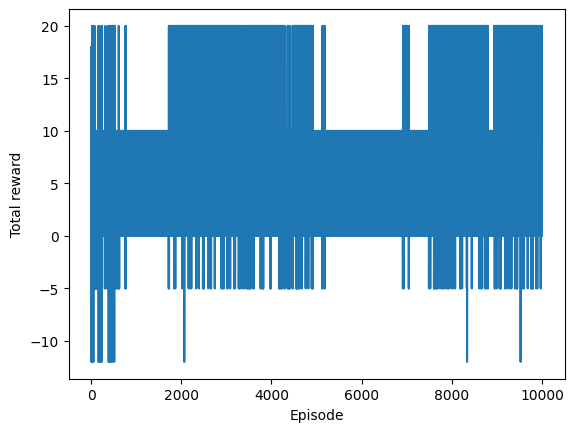

In [27]:
env = GridEnvironment()
agent = RandomAgent(env)

#Initialize Q-table
Q = np.zeros([env.observation_space.n, env.action_space.n])

#Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay_rate = 0.001
num_episodes = 10000
max_timesteps = 100

#Lists for storing rewards
rewards = []
total_reward = 0

#Q-learning algorithm
for i in range(num_episodes):
    obs1,info = env.reset()
    if obs1[0] == 1:
      state = 0
    elif obs1[1] == 1:
      state = 5 
    elif obs1[2] == 1:
      state = 10
    elif obs1[3] == 1:
      state = 15
    elif obs1[4] == 1:
      state = 20
    elif obs1[5] == 1:
      state = 1
    elif obs1[6] == 1:
      state = 6
    elif obs1[7] == 1:
      state = 11
    elif obs1[8] == 1:
      state = 16
    elif obs1[9] == 1:
      state = 21
    elif obs1[10] == 1:
      state = 2
    elif obs1[11] == 1:
      state = 7
    elif obs1[12] == 1:
      state = 12
    elif obs1[13] == 1:
      state = 17
    elif obs1[14] == 1:
      state = 22  
    elif obs1[15] == 1:
      state = 3 
    elif obs1[16] == 1:
      state = 8
    elif obs1[17] == 1:
      state = 13
    elif obs1[18] == 1:
      state = 18
    elif obs1[19] == 1:
      state = 23  
    elif obs1[20] == 1:
      state = 4  
    elif obs1[21] == 1:
      state = 9
    elif obs1[22] == 1:
      state = 14
    elif obs1[23] == 1:
      state = 19    
    elif obs1[24] == 1:
      state = 24

    done = False
    timesteps = 0
    while not done and timesteps < max_timesteps:
        # Epsilon-greedy policy
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        obs2, reward, done, truncated, _ = env.step(action)
        if obs2[0] == 1:
          next_state = 0
        elif obs2[1] == 1:
          next_state = 5 
        elif obs2[2] == 1:
          next_state = 10
        elif obs2[3] == 1:
          next_state = 15
        elif obs2[4] == 1:
          next_state = 20
        elif obs2[5] == 1:
          next_state = 1
        elif obs2[6] == 1:
          next_state = 6
        elif obs2[7] == 1:
          next_state = 11
        elif obs2[8] == 1:
          next_state = 16
        elif obs2[9] == 1:
          next_state = 21
        elif obs2[10] == 1:
          next_state = 2
        elif obs2[11] == 1:
          next_state = 7
        elif obs2[12] == 1:
          next_state = 12
        elif obs2[13] == 1:
          next_state = 17
        elif obs2[14] == 1:
          next_state = 22  
        elif obs2[15] == 1:
          next_state = 3 
        elif obs2[16] == 1:
          next_state = 8
        elif obs2[17] == 1:
          next_state = 13
        elif obs2[18] == 1:
          next_state = 18
        elif obs2[19] == 1:
          next_state = 23  
        elif obs2[20] == 1:
          next_state = 4  
        elif obs2[21] == 1:
          next_state = 9
        elif obs2[22] == 1:
          next_state = 14
        elif obs2[23] == 1:
          next_state = 19    
        elif obs2[24] == 1:
          next_state = 24
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
        state = next_state
        total_reward += reward
        timesteps += 1

    rewards.append(total_reward)
    total_reward = 0

    # Decay epsilon
    epsilon = max(0.1, epsilon - epsilon_decay_rate)

env.close()

#Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

Hyperparameters

In [21]:
# Hyperparameters
gamma_list = [0.9, 0.95, 0.99]
epsilon_decay_list = [0.001, 0.01, 0.1]
epsilon_min_list = [0.01, 0.1, 0.5]
epsilon_max_list = [1.0, 0.5, 0.1]
num_episodes_list = [5000, 10000, 15000]
max_timesteps_list = [100, 200, 300]

# Function to choose action based on epsilon-greedy strategy
def choose_action(state, q_table, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample() # Explore action space
    else:
        return np.argmax(q_table[state]) # Exploit learned values


# Function to decay epsilon
def decay_epsilon(epsilon, epsilon_decay, epsilon_min, epsilon_max):
    return max(epsilon_min, min(epsilon_max, epsilon * epsilon_decay))

# Function for hyperparameter tuning
def tune_hyperparameters():
    best_reward = -float('inf')
    for gamma in gamma_list:
        for epsilon_decay in epsilon_decay_list:
            for epsilon_min in epsilon_min_list:
                for epsilon_max in epsilon_max_list:
                    for num_episodes in num_episodes_list:
                        for max_timesteps in max_timesteps_list:
                            # Initialize Q-table
                            q_table = np.zeros([env.observation_space.n, env.action_space.n])
                            # Hyperparameters
                            alpha = 0.1
                            epsilon = 1.0
                            # Rewards
                            total_rewards = []
                            # Q-learning algorithm
                            for i in range(num_episodes):
                                obs1, info = env.reset()
                                if obs1[0] == 1:
                                  state = 0
                                elif obs1[1] == 1:
                                  state = 5 
                                elif obs1[2] == 1:
                                  state = 10
                                elif obs1[3] == 1:
                                  state = 15
                                elif obs1[4] == 1:
                                  state = 20
                                elif obs1[5] == 1:
                                  state = 1
                                elif obs1[6] == 1:
                                  state = 6
                                elif obs1[7] == 1:
                                  state = 11
                                elif obs1[8] == 1:
                                  state = 16
                                elif obs1[9] == 1:
                                  state = 21
                                elif obs1[10] == 1:
                                  state = 2
                                elif obs1[11] == 1:
                                  state = 7
                                elif obs1[12] == 1:
                                  state = 12
                                elif obs1[13] == 1:
                                  state = 17
                                elif obs1[14] == 1:
                                  state = 22  
                                elif obs1[15] == 1:
                                  state = 3 
                                elif obs1[16] == 1:
                                  state = 8
                                elif obs1[17] == 1:
                                  state = 13
                                elif obs1[18] == 1:
                                  state = 18
                                elif obs1[19] == 1:
                                  state = 23  
                                elif obs1[20] == 1:
                                  state = 4  
                                elif obs1[21] == 1:
                                  state = 9
                                elif obs1[22] == 1:
                                  state = 14
                                elif obs1[23] == 1:
                                  state = 19    
                                elif obs1[24] == 1:
                                  state = 24
                                action = choose_action(state, q_table, epsilon)
                                total_reward = 0
                                for t in range(max_timesteps):
                                    # Take action
                                    obs2, reward, done, truncated, info = env.step (action)
                                    if obs2[0] == 1:
                                      next_state = 0
                                    elif obs2[1] == 1:
                                      next_state = 5 
                                    elif obs2[2] == 1:
                                      next_state = 10
                                    elif obs2[3] == 1:
                                      next_state = 15
                                    elif obs2[4] == 1:
                                      next_state = 20
                                    elif obs2[5] == 1:
                                      next_state = 1
                                    elif obs2[6] == 1:
                                      next_state = 6
                                    elif obs2[7] == 1:
                                      next_state = 11
                                    elif obs2[8] == 1:
                                      next_state = 16
                                    elif obs2[9] == 1:
                                      next_state = 21
                                    elif obs2[10] == 1:
                                      next_state = 2
                                    elif obs2[11] == 1:
                                      next_state = 7
                                    elif obs2[12] == 1:
                                      next_state = 12
                                    elif obs2[13] == 1:
                                      next_state = 17
                                    elif obs2[14] == 1:
                                      next_state = 22  
                                    elif obs2[15] == 1:
                                      next_state = 3 
                                    elif obs2[16] == 1:
                                      next_state = 8
                                    elif obs2[17] == 1:
                                      next_state = 13
                                    elif obs2[18] == 1:
                                      next_state = 18
                                    elif obs2[19] == 1:
                                      next_state = 23  
                                    elif obs2[20] == 1:
                                      next_state = 4  
                                    elif obs2[21] == 1:
                                      next_state = 9
                                    elif obs2[22] == 1:
                                      next_state = 14
                                    elif obs2[23] == 1:
                                      next_state = 19    
                                    elif obs2[24] == 1:
                                      next_state = 24

                                    next_action = choose_action(next_state, q_table, epsilon)
                                    
                                    # Update Q-table                            

                                    td_error = reward + gamma * np.max([next_state][:]) - q_table[state][action]
                                    q_table[state][action] += alpha * td_error
                                    
                                    # Update variables
                                    state = next_state
                                    action = next_action
                                    total_reward += reward
                                    if done:
                                        break
                                epsilon = decay_epsilon(epsilon, epsilon_decay, epsilon_min, epsilon_max)
                                total_rewards.append(total_reward)
                            # Check if current hyperparameters give better results
                            mean_reward = np.mean(total_rewards)
                            if mean_reward > best_reward:
                                best_reward = mean_reward
                                best_hyperparameters = {
                                    'gamma': gamma,
                                    'epsilon_decay': epsilon_decay,
                                    'epsilon_min': epsilon_min,
                                    'epsilon_max': epsilon_max,
                                    'num_episodes': num_episodes,
                                    'max_timesteps': max_timesteps
                                }
    return best_hyperparameters

# Hyperparameter tuning
best_hyperparameters = tune_hyperparameters()
print("Best hyperparameters:", best_hyperparameters)

Best hyperparameters: {'gamma': 0.95, 'epsilon_decay': 0.1, 'epsilon_min': 0.1, 'epsilon_max': 0.1, 'num_episodes': 15000, 'max_timesteps': 300}


In [ ]:
References
1- The Demo that professor has issued in the class
2-  The RL Environment Visualization that has been introduced in Assigmnemt-3 thread.